In [1]:
import cbc, cbc_dp
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pyqtgraph as pg
import pickle
import pygmo
from numpy import ma
from scipy import constants
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cor_path = "exp_results/scan_{0:05}/scan_streaks_{0:05}.h5"
cor_data_path = 'corrected_data/corrected_data'
streaks_mask_path = 'corrected_data/streaks_mask'
bgd_path = 'corrected_data/background'
data_path = 'data/data'
mask_path = 'data/mask'

f135 = h5py.File(cor_path.format(135), 'r')
b12_cor_data = f135[cor_data_path][:]
b12_streaks_mask = f135[streaks_mask_path][:]
b12_data = f135[data_path][:]
b12_mask = f135[mask_path][:]
b12_bgd = f135[bgd_path]

In [3]:
pix_size = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
rot_axis = np.array([0, 1, 0])
b12_det_pos = np.array([115.3, 129.5, 107.9])
lys_det_pos = np.array([1480 * pix_size, 1155 * pix_size, 150.0])
b12_exp = cbc_dp.ScanSetup(rot_axis=rot_axis,
                           pix_size=pix_size,
                           det_pos=b12_det_pos)
pupil_size = np.radians([0.65, 1.05])

frame_shape = b12_mask.shape

In [4]:
b12_scan = cbc_dp.ScanStreaks(raw_lines=f135['streaks/lines'][:],
                              exp_set=b12_exp,
                              frame_idxs=f135['streaks/frame_idxs'][:])
b12_qs = b12_scan.kout_ref(np.radians(np.arange(101)))
basis_full = b12_qs.index()
rec_basis_full = cbc.rec_basis(basis_full)

# Cython

In [3]:
%load_ext cython

In [134]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def index_kout_lines(float_t[:, :, ::1] vot_vec, float_t num_ap_x, float_t num_ap_y):
    """
    Return source lines coordinates for a diffraction streaks model

    source - source line origins
    rec_vec - reciprocal vectors
    num_ap_x, num_ap_y - numerical apertires in x- and y-axes
    """
    cdef:
        int a = vot_vec.shape[0], b = vot_vec.shape[1], kk, i, j, k
        uint8_t[:, ::1] mask = np.zeros((a, b), dtype=np.uint8)
        float_t rec_abs, source_phi, source_th, source_x, source_y, source_z
        float_t source_prd, coeff1, coeff2, alpha, betta, gamma, delta, sol_1, sol_2
        float_t[::1] bounds = np.array([num_ap_x, -num_ap_x, num_ap_y, -num_ap_y], dtype=np.float64)
        float_t[:, :, :, ::1] source_lines = np.zeros((a, b, 2, 3), dtype=np.float64)
    for i in range(a):
        for j in range(b):
            rec_abs = sqrt(vot_vec[i, j, 0]**2 + vot_vec[i, j, 1]**2 + vot_vec[i, j, 2]**2)
            source_phi = atan2(vot_vec[i, j, 1], vot_vec[i, j, 0])
            source_th = acos(-vot_vec[i, j, 2] / rec_abs) - acos(rec_abs / 2)
            source_x = -sin(source_th) * cos(source_phi)
            source_y = -sin(source_th) * sin(source_phi)
            source_z =  cos(source_th)
            source_prd = source_x * vot_vec[i, j, 0] + source_y * vot_vec[i, j, 1] + source_z * vot_vec[i, j, 2]
            kk = 0
            for k in range(4):
                coeff1 = source_prd - bounds[k] * vot_vec[i, j, k // 2]
                coeff2 = vot_vec[i, j, (3 - k) // 2]
                alpha = coeff2**2 + vot_vec[i, j, 2]**2
                betta = coeff2 * coeff1
                gamma = coeff1**2 - vot_vec[i, j, 2]**2 * (1 - bounds[k]**2)
                delta = betta**2 - alpha * gamma
                sol_1 = (betta + sqrt(delta)) / alpha
                sol_2 = (betta - sqrt(delta)) / alpha
                if abs(sol_1) < abs(bounds[3 - k]):
                    source_lines[i, j, kk, k // 2] = vot_vec[i, j, k // 2] + bounds[k]
                    source_lines[i, j, kk, (3 - k) // 2] = vot_vec[i, j, (3 - k) // 2] + sol_1
                    source_lines[i, j, kk, 2] = vot_vec[i, j, 2] + sqrt(1 - bounds[k]**2 - sol_1**2)
                    kk += 1
                if delta != 0 and abs(sol_2) < abs(bounds[3 - k]):
                    source_lines[i, j, kk, k // 2] = vot_vec[i, j, k // 2] + bounds[k]
                    source_lines[i, j, kk, (3 - k) // 2] = vot_vec[i, j, (3 - k) // 2] + sol_2
                    source_lines[i, j, kk, 2] = vot_vec[i, j, 2] + sqrt(1 - bounds[k]**2 - sol_2**2)
                    kk += 1
                if kk == 2:
                    mask[i, j] = 1
                    break
    return np.asarray(source_lines), np.asarray(mask).astype(bool)

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def kout_source(float_t[:, :, ::1] kout_exp):
    cdef:
        int a = kout_exp.shape[0], i
        float_t dkout_x, dkout_y, prod, source_x, source_y
        float_t[:, ::1] kout_source = np.empty((a, 3), dtype=np.float64)
    for i in range(a):
        dkout_x = kout_exp[i, 1, 0] - kout_exp[i, 0, 0]
        dkout_y = kout_exp[i, 1, 1] - kout_exp[i, 0, 1]
        prod = kout_exp[i, 1, 0] * dkout_y - kout_exp[i, 1, 1] * dkout_x
        kout_source[i, 0] = dkout_y * prod / (dkout_x**2 + dkout_y**2)
        kout_source[i, 1] = -dkout_x * prod / (dkout_x**2 + dkout_y**2)
        kout_source[i, 2] = sqrt(1 - kout_source[i, 0]**2 - kout_source[i, 1]**2)
    return np.asarray(kout_source)

# Simulation results

In [2]:
datapath = 'data/data'
res1 = h5py.File('results/diff_08-08-2019_21-53-29.hdf5', 'r')['results/diffracted lightwave values']
file2 = h5py.File('results/diff_07-09-2019_05-32-33.hdf5', 'r')
res3 = h5py.File('results/diff_25-09-2019_08-17-22.hdf5', 'r')[datapath]
res4 = h5py.File('results/diff_07-01-2020_14-41-05.hdf5', 'r')[datapath]
res5 = h5py.File('results/diff_09-01-2020_12-40-10.hdf5', 'r')[datapath]

# Functional optimization

## Present approach

In [8]:
frame_idx = 35
rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(frame_idx)).T)
rec_sizes = np.sqrt((rec_basis**2).sum(axis=1))
start_point = np.concatenate((np.zeros(3), rec_sizes, np.zeros(3)))
rot_tf = cbc_dp.RCBI(lines=b12_scan[frame_idx].raw_lines,
                     exp_set=b12_exp,
                     num_ap=pupil_size,
                     rec_basis=rec_basis,
                     tol=(0.05, 0.05, np.radians(10)))

algo = pygmo.algorithm(pygmo.de(gen=2000))
algo.set_verbosity(100)
prob = pygmo.problem(rot_tf)
pop = pygmo.population(prob, size=50)
pop = algo.evolve(pop)
champion = pop.champion_x
print(prob.fitness(start_point), pop.champion_f, champion, sep='\n')

[0.01125434]
[0.0056323]
[ 0.00051876 -0.00491133 -0.03135749  0.04558532  0.03199738  0.02748952
  0.17436569  0.01304411 -0.15917482]


In [19]:
frame_idx = 50
rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(frame_idx)).T)
start_point = np.concatenate((np.zeros(3), rec_basis.ravel()))
full_tf = cbc_dp.FCBI(lines=b12_scan[frame_idx].raw_lines,
                      exp_set=b12_exp,
                      num_ap=pupil_size,
                      rec_basis=rec_basis,
                      tol=(0.05, 0.15),
                      pen_coeff=10)

algo = pygmo.algorithm(pygmo.de(gen=2000))
algo.set_verbosity(100)
prob = pygmo.problem(full_tf)
pop = pygmo.population(prob, size=50)
pop = algo.evolve(pop)
champion = pop.champion_x
print(full_tf.fitness(start_point), pop.champion_f, champion, sep='\n')

[0.007606350061304066]
[0.00318992]
[ 0.00159897 -0.00573282 -0.0435491   0.00649615 -0.04501208  0.0065452
  0.01941358  0.00618606  0.024874    0.02257904  0.0013357  -0.01690536]


In [20]:
model = cbc_dp.RectModel(rec_lat=cbc_dp.BallLattice(full_tf.rec_basis(champion), 0.7),
                         num_ap=pupil_size)
model_lines = full_tf.det_pts(model.kout_lines(), champion)
model_pts = full_tf.det_pts(model.kout(), champion)

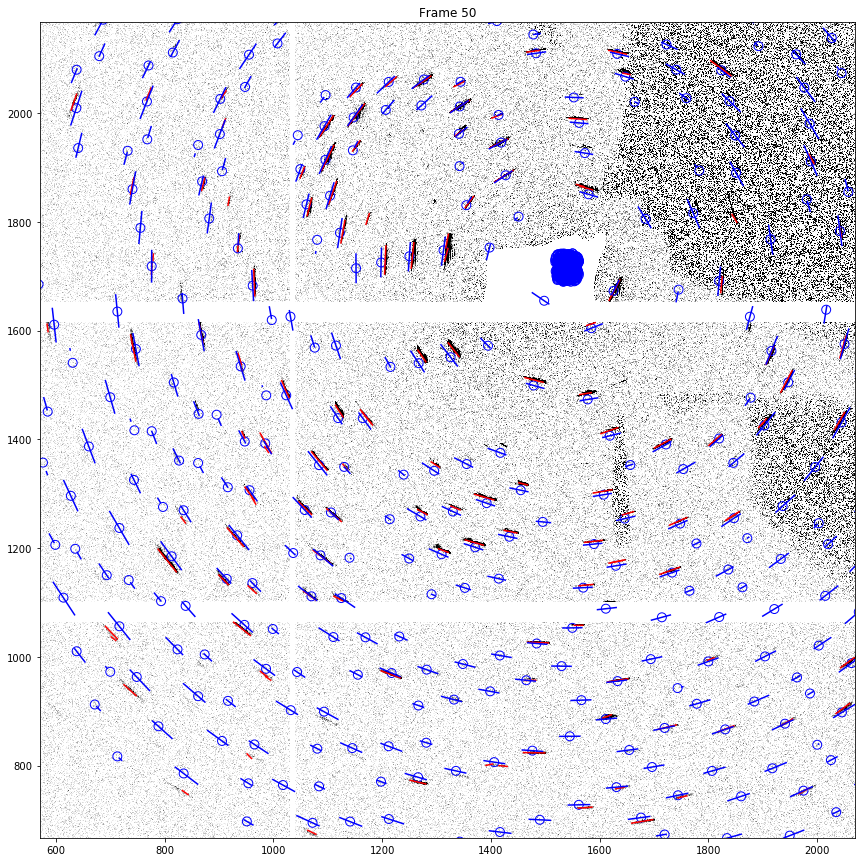

In [21]:
%matplotlib inline
exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx],
          vmin=0, vmax=20, cmap='gray_r')
for line in b12_scan[frame_idx].raw_lines:
    ax.plot(line[..., 0], line[..., 1], 'r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
for line in model_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
plt.scatter(b12_det_pos[0] / pix_size, b12_det_pos[1] / pix_size, 20, 'b')
ax.set_xlim(570, 2070)
ax.set_ylim(667, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

In [17]:
hkl_idxs = full_tf.hkl_idxs(champion)
model = cbc_dp.RectModel(rec_lat=cbc_dp.RecLattice(full_tf.rec_basis(champion), hkl_idxs),
                         num_ap=pupil_size)
model_lines = full_tf.det_pts(model.kout_lines(), champion)
model_pts = full_tf.det_pts(model.kout(), champion)

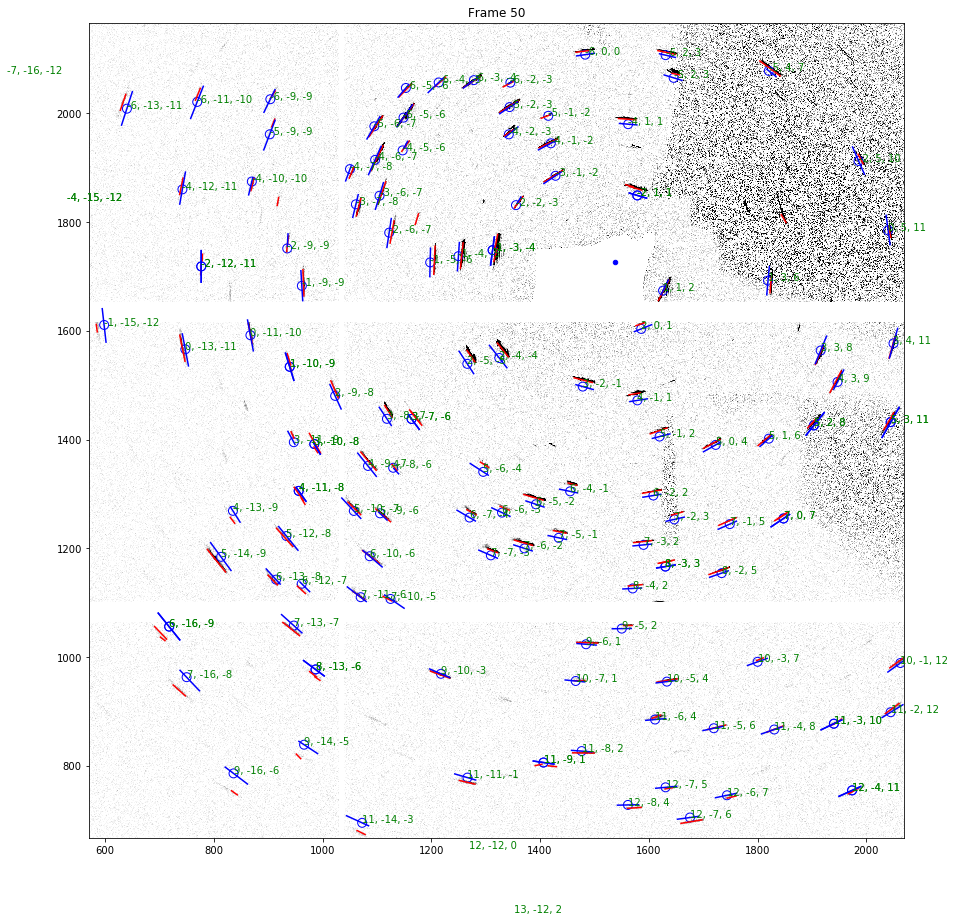

In [18]:
%matplotlib inline
exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50, cmap='gray_r')
for line in b12_scan[frame_idx].raw_lines:
    ax.plot(line[..., 0], line[..., 1], 'r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
for line in model_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
plt.scatter(b12_det_pos[0] / pix_size, b12_det_pos[1] / pix_size, 20, 'b')
for pt, hkl in zip(model_pts, model.hkl_idxs):
    ax.text(pt[0], pt[1], '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl.astype(np.int)), color='g')
ax.set_xlim(570, 2070)
ax.set_ylim(667, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

In [160]:
archi = pygmo.archipelago()
for idx, b12_frame in enumerate(b12_scan):
    rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(idx)).T)
    full_tf = cbc_dp.FCBI(lines=b12_frame.raw_lines,
                          exp_set=b12_exp,
                          num_ap=0.9 * pupil_size,
                          rec_basis=rec_basis,
                          tol=(0.15, 0.15))
    prob = pygmo.problem(full_tf)
    populations = [pygmo.population(size=36, prob=prob, b=pygmo.mp_bfe()) for _ in range(5)]
    for pop in populations:
        archi.push_back(algo=pygmo.de(500), pop=pop)

In [111]:
index = np.stack([island.get_population().champion_x for island in islands], axis=-1)

In [54]:
index_sol = np.stack([island.get_champions_x() for island in islands], axis=0)
index_f = np.stack([island.get_champions_f() for island in islands], axis=-1)

## Modelling approach

# Indexing results

In [12]:
index_list = h5py.File('exp_results/index_sol.h5', 'r')['data/index_sol'][:].reshape((20, -1, 12), order='F')
index_f = h5py.File('exp_results/index_sol.h5', 'r')['data/index_f'][:].reshape((20, -1), order='F')
idxs = (np.argmin(index_f, axis=0), np.arange(index_list.shape[1]))
index_sol = index_list[idxs]

In [10]:
index_list = h5py.File('exp_results/index_sol_2.h5', 'r')['data/index_sol'][:].reshape((20, -1, 12), order='F')
index_f = h5py.File('exp_results/index_sol_2.h5', 'r')['data/index_f'][:].reshape((20, -1), order='F')
idxs = (np.argmin(index_f, axis=0), np.arange(index_list.shape[1]))
index_sol = index_list[idxs]

In [12]:
hkl_list = []
thetas = np.radians(np.arange(101))
for theta, champion, b12_frame in zip(thetas, index_sol, b12_scan):
    rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-theta).T)
    full_tf = cbc_dp.FCBI(lines=b12_frame.raw_lines,
                          exp_set=b12_exp,
                          num_ap=0.9 * pupil_size,
                          rec_basis=rec_basis,
                          tol=(0.05, 0.12))
    hkl_list.append(full_tf.hkl_idxs(champion))

In [13]:
kins_list = []
thetas = np.radians(np.arange(101))
for theta, champion, b12_frame in zip(thetas, index_sol, b12_scan):
    rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-theta).T)
    full_tf = cbc_dp.FCBI(lines=b12_frame.raw_lines,
                          exp_set=b12_exp,
                          num_ap=0.9 * pupil_size,
                          rec_basis=rec_basis,
                          tol=(0.05, 0.12))
    kout_exp = full_tf.kout_exp(champion)
    hkl_idxs = full_tf.hkl_idxs(champion)
    rec_vec = hkl_idxs.dot(full_tf.rec_basis(champion))
    kins_list.append(kout_exp - rec_vec[:, None])

In [19]:
out_file = h5py.File('exp_results/scan_indexed.h5', 'w')

out_group = out_file.create_group('streaks')
out_group.create_dataset('counts', data=b12_scan.shapes)
out_group.create_dataset('lines', data=b12_scan.raw_lines)
b12_scan.exp_set.save(out_group)
out_group.create_dataset('intensities', data=b12_scan.intensities(b12_data*b12_mask))
out_group.create_dataset('snr', data=b12_scan.snr(b12_data*b12_mask, b12_bgd))

index_group = out_file.create_group('indexing')
index_group.create_dataset('data/index_sol', data=index_sol)
index_group.create_dataset('data/index_f', data=index_f)
index_group.create_dataset('proc/index_sol', data=index)
index_group.create_dataset('proc/hkl_ind', data=np.concatenate(hkl_list))
out_file.close()

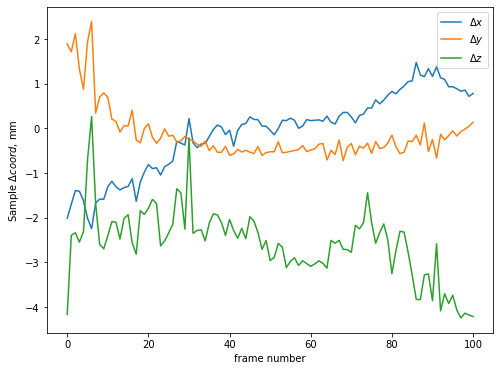

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(index_sol[:, 0] * b12_det_pos[0], label='$\Delta x$')
ax.plot(index_sol[:, 1] * b12_det_pos[1], label='$\Delta y$')
ax.plot(index_sol[:, 2] * b12_det_pos[2], label='$\Delta z$')
ax.set_xlabel('frame number')
ax.set_ylabel('Sample $\Delta coord$, mm')
ax.legend()
plt.show()
# plt.savefig('sample_pos.pdf')

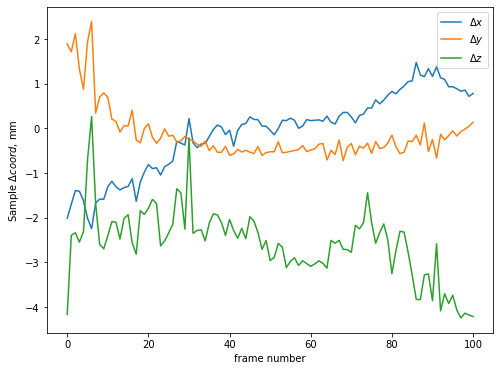

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(index_sol[:, 0] * b12_det_pos[0], label='$\Delta x$')
ax.plot(index_sol[:, 1] * b12_det_pos[1], label='$\Delta y$')
ax.plot(index_sol[:, 2] * b12_det_pos[2], label='$\Delta z$')
ax.set_xlabel('frame number')
ax.set_ylabel('Sample $\Delta coord$, mm')
ax.legend()
plt.show()
# plt.savefig('sample_pos.pdf')

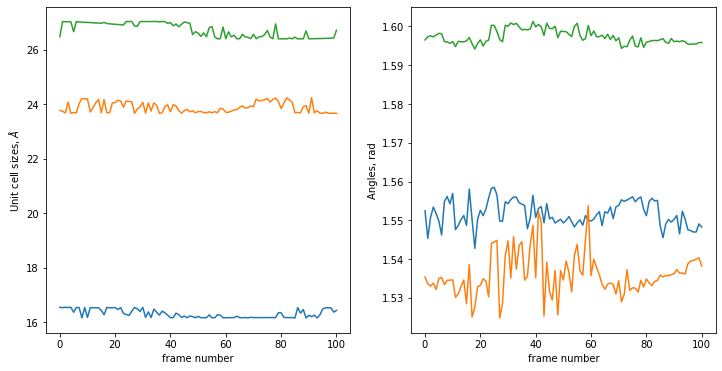

In [98]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
rec_mat = index_sol[:, 3:].reshape((101, 3, 3))
rec_sizes = np.sqrt((rec_mat**2).sum(axis=-1))
or_mats = rec_mat / rec_sizes[:, :, None]
alpha12 = np.arccos((or_mats[:, 0] * or_mats[:, 1]).sum(axis=1))
alpha23 = np.arccos((or_mats[:, 1] * or_mats[:, 2]).sum(axis=1))
alpha13 = np.arccos((or_mats[:, 0] * or_mats[:, 2]).sum(axis=1))
axes[0].plot(wavelength / rec_sizes[:, 0] * 1e7, label='Abs(a)')
axes[0].plot(wavelength / rec_sizes[:, 1] * 1e7, label='Abs(b)')
axes[0].plot(wavelength / rec_sizes[:, 2] * 1e7, label='Abs(c)')
axes[0].set_xlabel('frame number')
axes[0].set_ylabel('Unit cell sizes, $\AA$')
axes[1].plot(alpha12)
axes[1].plot(alpha23)
axes[1].plot(alpha13)
axes[1].set_ylabel('Angles, rad')
axes[1].set_xlabel('frame number')
plt.savefig('figures/rec_basis.pdf')

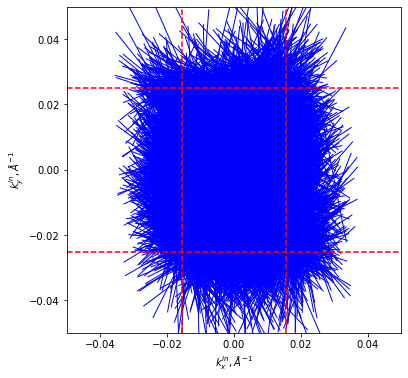

In [110]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6))
NA_x, NA_y = pupil_size[0], pupil_size[1]
ax = fig.add_subplot(111)
for kins_chunk in kins_list:
    for line in kins_chunk:
        ax.plot(line[..., 0] / wavelength * 1e-7,
                line[..., 1] / wavelength * 1e-7, 'b', linewidth=1)
ax.plot(np.linspace(-0.05, 0.05), NA_y / wavelength * 1e-7 * np.ones(50), '--r')
ax.plot(np.linspace(-0.05, 0.05), -NA_y / wavelength * 1e-7 * np.ones(50), '--r')
ax.plot(NA_x / wavelength * 1e-7 * np.ones(50), np.linspace(-0.05, 0.05), '--r')
ax.plot(-NA_x / wavelength * 1e-7 * np.ones(50), np.linspace(-0.05, 0.05), '--r')
ax.set_xlim(-0.05, 0.05)
ax.set_ylim(-0.05, 0.05)
ax.set_xlabel('$k^{in}_x, \AA^{-1}$')
ax.set_ylabel('$k^{in}_y, \AA^{-1}$')
plt.savefig('figures/kin_pupil.pdf')

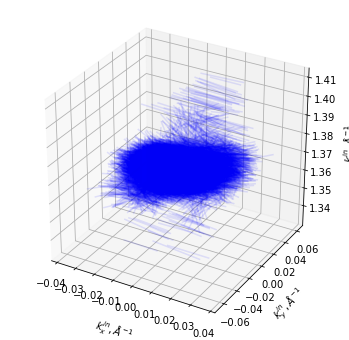

In [30]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
for line in kins_list:
    ax.plot(line[:, 0] / wavelength * 1e-7,
            line[:, 1] / wavelength * 1e-7,
            line[:, 2] / wavelength * 1e-7, 'b', alpha=0.1)
ax.set_xlabel('$k^{in}_x, \AA^{-1}$', labelpad=10)
ax.set_ylabel('$k^{in}_y, \AA^{-1}$', labelpad=10)
ax.set_zlabel('$k^{in}_z, \AA^{-1}$', labelpad=10)
plt.savefig('figures/kin_map.pdf', bbox_inches='tight', pad_inches=1)

## Intensity estimation

In [4]:
from scipy.ndimage import median_filter, binary_fill_holes, binary_dilation
from skimage.draw import line

In [7]:
frame_idx = 50
lsd = cbc_dp.LineSegmentDetector(scale=0.6, sigma_scale=0.4)
streaks = lsd.det_frame_raw(median_filter(b12_cor_data[frame_idx], 3))
noise_mask = cbc_dp.utils.draw_lines_aa(streaks.astype(np.int64), 1, frame_shape[0], frame_shape[1])
noise_mask = qbinary_dilation(noise_mask, iterations=3)
noise_mask = binary_fill_holes(noise_mask)

In [14]:
streaks = b12_scan[frame_idx]
frame_hkl = hkl_list[frame_idx]
hkl_uniq = np.unique(frame_hkl, axis=0)
idxs = np.where((frame_hkl == hkl_uniq[0]).all(axis=1))
streaks_list = [streaks[np.where((frame_hkl == hkl).all(axis=1))] for hkl in hkl_uniq]

In [15]:
from scipy.ndimage import label, labeled_comprehension

In [16]:
class DiffData():
    def __init__(self, data, mask):
        self.data, self.mask = data, mask
        self._label_data()
        self._norm_data()
    
    def _label_data(self):
        self.labels, lbl_num = label(self.mask)
        self.n_labels = np.arange(1, lbl_num + 1)
        
    def _label_func(self, val, pos):
        if val.max() > val.mean() + 3.2 * val.std():
            self.norm_data[pos] = self.norm_data[pos] / val.mean()
        else:
            self.norm_data[pos] = 0
        
    def _norm_data(self):
        self.norm_data = (self.data * self.mask).ravel()
        labeled_comprehension(self.data, self.labels, self.n_labels, self._label_func,
                              float, None, True)
        self.norm_data = self.norm_data.reshape(self.data.shape)

In [32]:
diff_data = DiffData(np.copy(b12_cor_data), np.copy(b12_streaks_mask))

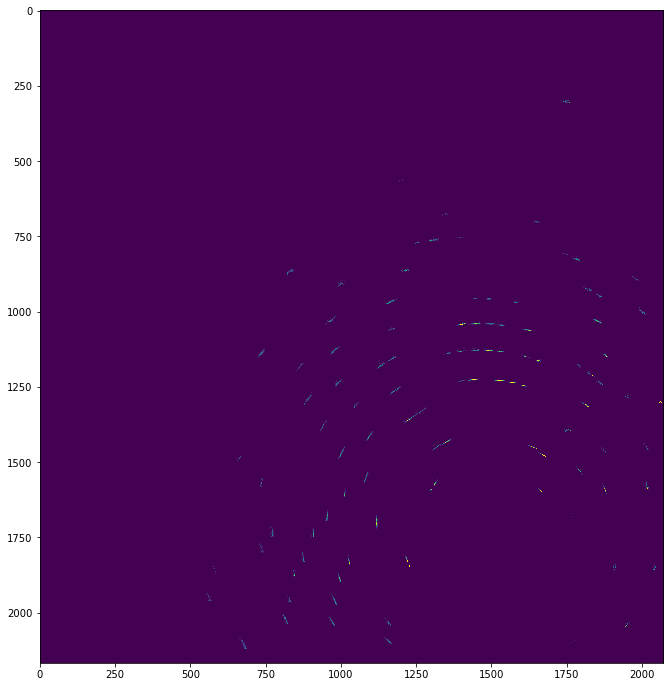

In [33]:
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.imshow(diff_data.norm_data[frame_idx], vmin=0, vmax=10)
plt.show()

In [ ]:
b12_scan_2 = lsd.det_frame(diff_data.norm_data, b12_exp, d_tau=1.8, d_n=1.4)
b12_scan.size, b12_scan_2.size

In [17]:
frame_idx = 90
diff_data = DiffData(np.copy(b12_cor_data[frame_idx]), np.copy(b12_streaks_mask[frame_idx]))
streaks = lsd.det_frame(diff_data.norm_data, b12_exp, d_tau=2., d_n=1.5)
streaks.size, diff_data.n_labels[-1]

(86, 117)

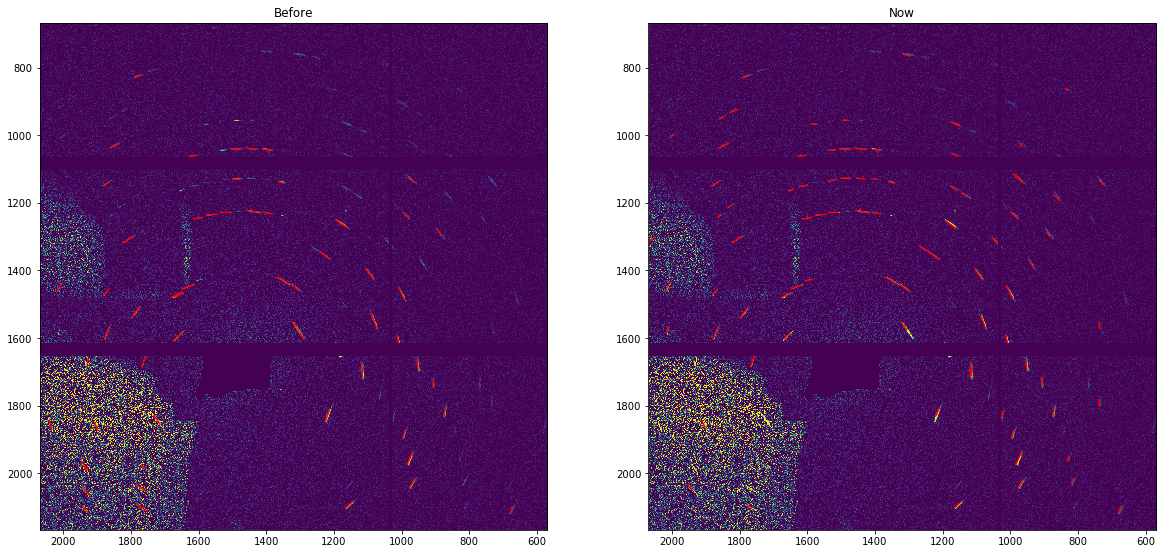

In [26]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for ax in axes:
    ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50)
    ax.set_xlim(frame_shape[1], frame_shape[1] - 1500)
    ax.set_ylim(frame_shape[0], frame_shape[0] - 1500)
for line in b12_scan[frame_idx].raw_lines:
    axes[0].plot(line[:, 0], line[:, 1], 'r')
for line in streaks.raw_lines:
    axes[1].plot(line[:, 0], line[:, 1], 'r')
axes[0].set_title('Before')
axes[1].set_title('Now')
plt.show()

In [386]:
theta = np.radians(-frame_idx)
champion = index_sol[frame_idx]
rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(theta).T)
full_tf = cbc_dp.FCBI(lines=streaks.raw_lines,
                      exp_set=b12_exp,
                      num_ap=pupil_size,
                      rec_basis=rec_basis,
                      tol=(0.05, 0.12))
model = cbc_dp.RectModel(rec_lat=cbc_dp.RecLattice(full_tf.rec_basis(champion), hkl_uniq),
                         num_ap=pupil_size)

In [429]:
max_cnt = np.max(b12_cor_data[frame_idx] * strks_mask)
max_bgd = np.max(b12_bgd[frame_idx] * strks_mask)
max_int = np.max(b12_data[frame_idx] * strks_mask)
max_cnt, max_bgd, max_int

(1886.8470509144213, 2811.0, 38654705655.0)

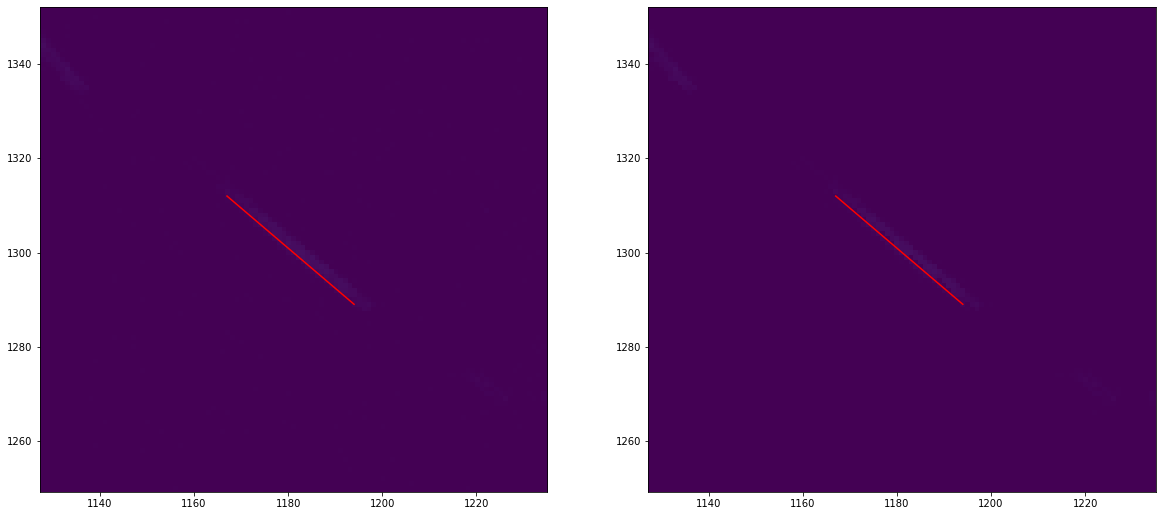

In [430]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[frame_idx], vmin=0, vmax=max_cnt)
axes[1].imshow(b12_cor_data[frame_idx] * noise_mask, vmin=0, vmax=max_cnt)
for ax in axes:
    for line in streaks_list[idx].raw_lines.astype(int):
        ax.plot(line[:, 0], line[:, 1], 'r', 100)
offset = 40
for ax in axes:
    ax.set_xlim(streaks_list[idx].raw_lines[..., 0].min() - offset,
                streaks_list[idx].raw_lines[..., 0].max() + offset)
    ax.set_ylim(streaks_list[idx].raw_lines[..., 1].min() - offset,
                streaks_list[idx].raw_lines[..., 1].max() + offset)
plt.show()

# Gaussian beam

In [38]:
def thdiv(waist, wavelength):
    return wavelength / np.pi / waist

def zR(waist, wavelength):
    return np.pi * waist**2 / wavelength

def R(zs, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    return zs + zr**2 / zs

def wz(z, waist, wavelength):
    return waist * np.sqrt(1 + (z / zR(waist, wavelength)**2))

def gaussian(xs, ys, zs, waist=1e-4, wavelength=1.5e-7):
    k = 2 * np.pi / wavelength
    zr = np.pi * waist**2 / wavelength
    Rs = zs + zr**2 / zs
    wz = waist * sqrt(1 + z**2 / zr**2)
    return np.pi**-1 * waist**-1 * wz**-1 * np.exp(-(xs**2 + ys**2) / wz**2) * np.exp(-1j * (k * z - np.arctan(zs / zr) + k * (xs**2 + ys**2) / 2 / Rs))

In [39]:
thdiv(waist, wavelength)

0.0477464829275686

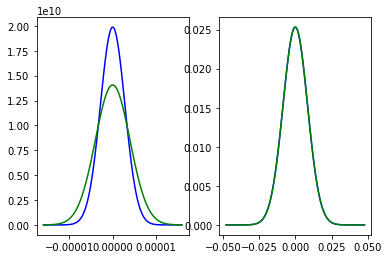

In [50]:
%matplotlib inline
xs = np.linspace(-4 * waist, 4 * waist, 100)
us = np.abs(cbc.gaussian(xs, 0, 0, waist, wavelength))
us2 = np.abs(cbc.gaussian(xs, 0, zR(waist, wavelength), waist, wavelength))
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength), 100)
ufs = np.abs(cbc.gaussian_f(kxs, 0, 0, waist, wavelength))
ufs2 = np.abs(cbc.gaussian_f(kxs, 0, zR(waist, wavelength), waist, wavelength))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(xs, us, 'b-', xs, us2, 'g-')
ax2.plot(kxs, ufs, 'b-', kxs, ufs2, 'g-')
plt.show()

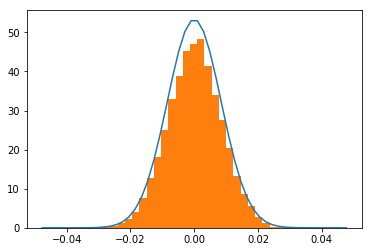

In [34]:
%matplotlib inline
knum = 10000
ks = cbc.gaussian_dist(knum, 0, waist, wavelength)
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength))
us = np.abs(cbc.gaussian_f(kxs, 0, 10, waist, wavelength)) * 4 * np.pi / thdiv(waist, wavelength)*2
plt.plot(kxs, us)
plt.hist(ks[:,0], 30, density=True)
plt.show()

In [ ]:
%matplotlib inline
_thdiv = thdiv(waist,wavelength)
kxs, kys = cbc.uniform_dist(100000, waist, wavelength)[:, 0:2].T
kxs2, kys2 = cbc.gaussian_dist(100000, waist, wavelength)[:, 0:2].T
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
ax1.hist2d(kxs, kys, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
ax2.hist2d(kxs2, kys2, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
plt.show()

# Convolution approximation and Henry's equations

In [3]:
def gaussian_dist(N, z, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    wz = waist * np.sqrt(1 + z**2 / zr**2)
    thdiv = wavelength / np.pi / wz
    kxs, kys = np.random.multivariate_normal([0, 0], [[thdiv**2 / 2, 0], [0, thdiv**2 / 2]], N).T
    return cbc.kout_parax(kxs, kys)

In [40]:
waist = 3e-6
wavelength = 1.5e-7
a, b, c = 2e-6, 2.5e-6, 1e-5
Nx, Ny, Nz = 10, 10, 1
detNx, detNy = 64, 64
pix_size = 2 * 55e-3
det_dist = 30
knum = 5000

In [4]:
%matplotlib inline
XS, YS, ZS = np.array([0, 0.5 * a]), np.zeros(2), np.zeros(2)
els = ['Au', 'Ag']; bs = np.zeros(2)
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz, XS, YS, ZS)
z0 = 1e-4
zs += z0
asf_coeffs = cbc.asf_coeffs(els, bs)
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
kins = cbc.gaussian_kins(xs, ys, zs, waist, wavelength)
us = cbc.gaussian(xs, ys, zs, waist, wavelength) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)
print(asf_coeffs.shape)

(2, 11)


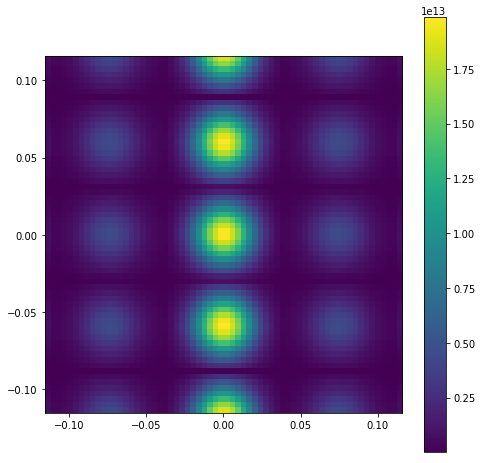

In [80]:
qabs = cbc.utils.q_abs(kouts, kins, wavelength)
asfs = cbc.utils.asf_sum(qabs, asf_coeffs)
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs * us * phs).sum(axis=(-2,-1)).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(8, 8))
plt.imshow(ints, extent=[kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

In [81]:
%time kjs = np.repeat(cbc.gaussian_dist(knum, waist, wavelength)[:,np.newaxis], xs.shape[-1], axis=1)
%time qabs2 = cbc.utils.q_abs(kouts, kjs, wavelength)
%time asfs2 = cbc.utils.asf_sum(qabs2, asf_coeffs)
%time phs2 = cbc.utils.phase_conv(kouts, kjs, xs, ys, zs, wavelength)
%time sfs2 = asfs2 * phs2
print(kjs.shape, qabs2.shape, asfs2.shape, phs2.shape)

CPU times: user 1.13 ms, sys: 533 µs, total: 1.66 ms
Wall time: 1.13 ms
CPU times: user 480 ms, sys: 203 ms, total: 683 ms
Wall time: 680 ms
CPU times: user 2.03 s, sys: 102 ms, total: 2.13 s
Wall time: 2.12 s
CPU times: user 1min 16s, sys: 416 ms, total: 1min 17s
Wall time: 1min 16s
CPU times: user 248 ms, sys: 197 ms, total: 445 ms
Wall time: 443 ms
(5000, 2, 3) (4096, 5000, 2) (4096, 5000, 2) (4096, 5000, 2)


In [82]:
uphs = cbc.gaussian_f(kjs[:,:,0], kjs[:,:,1], z0, waist, wavelength)
res2 = (uphs * sfs2).sum(axis=(-2,-1)).reshape(kxs.shape) / kjs.shape[0]
print(uphs.shape, res2.shape)

(5000, 2) (64, 64)


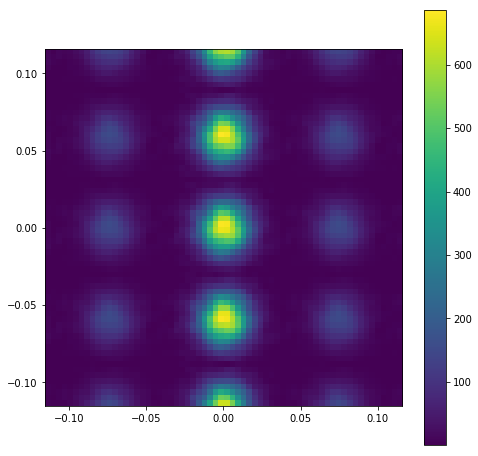

In [83]:
ints2 = np.abs(res2)
plt.figure(figsize=(8, 8))
plt.imshow(ints2, extent=[kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

# Lysozyme diffraction pattern

In [42]:
wavelength = 1.5e-7
f, ap, defoc = 2, 2.2e-2, 1e-4
waist = 4.5e-6
a, b, c = np.array([7.9e-6, 0, 0]), np.array([0, 7.9e-6, 0]), np.array([0, 0, 3.8e-6])
Nx, Ny, Nz = 20, 20, 20
r = 2e-4
detNx, detNy = 512, 512
pix_size = 55e-3
det_dist = 60

In [44]:
bragg = wavelength / 2 / np.sqrt(a.dot(a))
th_lens = 2 * ap / f
th_lens2 = 2 * wavelength / np.pi / waist
print(2 * bragg / th_lens, 2 * bragg / pix_size * det_dist)

0.863060989643268 20.713463751438432


In [45]:
beam = cbc.CircBeam(f, ap, wavelength)
diff = cbc.Diff(beam=beam,
                detector=cbc.Detector(det_dist=det_dist, detNx=detNx, detNy=detNy, pix_size=pix_size),
                lattice=cbc.BallLattice(cell=cbc.Cell.importpdb('4et8.pdb'), a=a, b=b, c=c, r=r))

In [ ]:
diffres = diff.calculate().pool()
diffres.write()

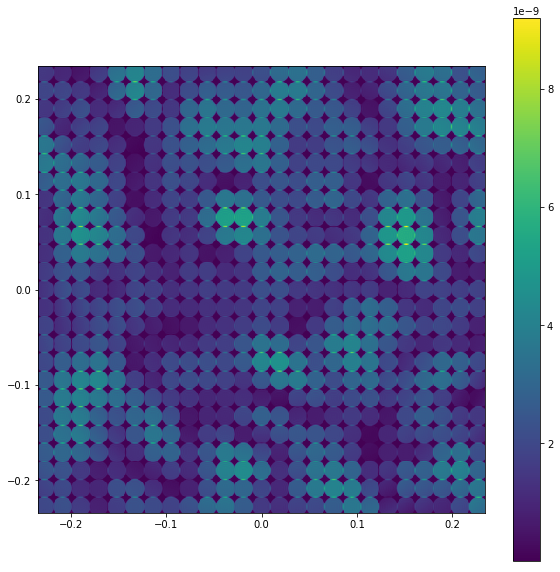

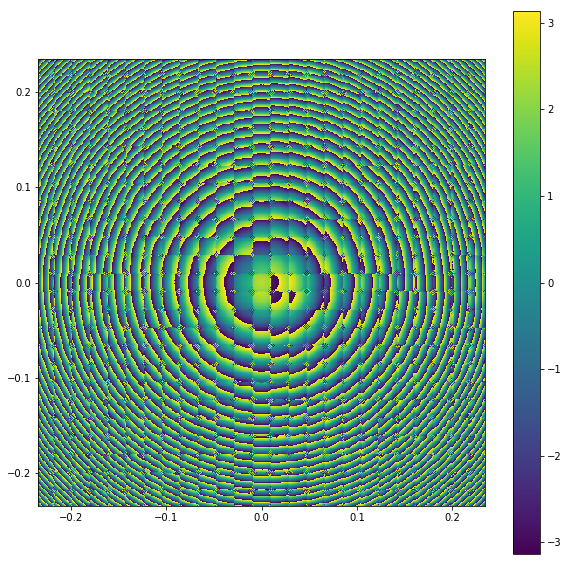

In [76]:
ints = np.abs(data[0])
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()
ang1 = np.angle(data[0])
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()

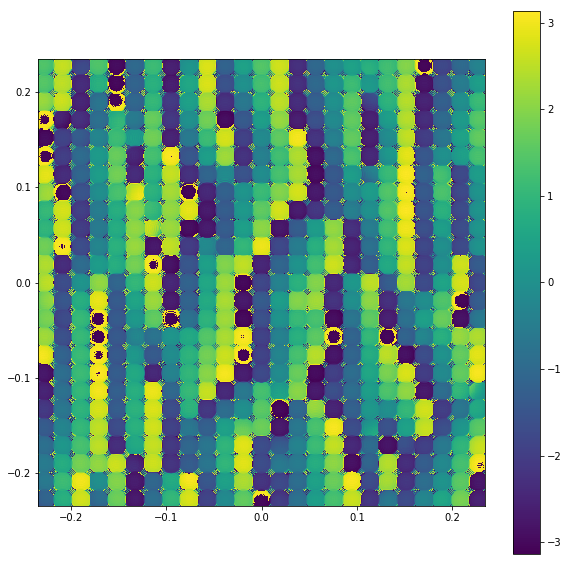

In [157]:
ang2 = np.angle(data[0] / np.exp(2j * np.pi / wavelength * 1e-4 * (1 - (data[1]**2 + data[2]**2) / 2)))
plt.figure(figsize=(10,10))
plt.imshow(ang2, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()

# Output values at the centers of diffraction orders

In [19]:
import numba as nb
from math import exp, cos, sin, pi

In [24]:
@nb.njit(nb.float64[:,:](nb.float64[:], nb.float64[:,:]), fastmath=True)
def asf_sum(ss, asfcoeffs):
    a = ss.size
    b = asfcoeffs.shape[0]
    asfs = np.empty((a, b), dtype=np.float64)
    ss = np.ascontiguousarray(ss)
    asfcoeffs = np.ascontiguousarray(asfcoeffs)
    for i in range(a):
        for j in range(b):
            dasf = 0.0
            for k in range(5):
                dasf += asfcoeffs[j,k] * exp(-ss[i]**2 * asfcoeffs[j,6+k])
            asfs[i,j] = (dasf + asfcoeffs[j,5]) * exp(-ss[i]**2 * asfcoeffs[j,-1])
    return asfs

@nb.njit(nb.complex128[:,:](nb.float64[:,:], nb.float64[:], nb.float64[:], nb.float64[:], nb.float64), fastmath=True)
def phase(kouts, xs, ys, zs, wavelength):
    a = kouts.shape[0]
    b = xs.size
    res = np.empty((a, b), dtype=np.complex128)
    kouts = np.ascontiguousarray(kouts)
    xs = np.ascontiguousarray(xs)
    ys = np.ascontiguousarray(ys)
    zs = np.ascontiguousarray(zs)
    for i in range(a):
        for j in range(b):
            _ph = kouts[i,0] * xs[j] + kouts[i,1] * ys[j] + kouts[i,2] * zs[j]
            res[i,j] = cos(2 * pi / wavelength * _ph) + sin(2 * pi / wavelength * _ph) * 1j
    return res

def gaussian_f(kxs, kys, zs, wavelength):
    return np.exp(-2j * np.pi / wavelength * np.multiply.outer((kxs**2 + kys**2) / 2, zs))

In [11]:
wavelength = 1.5e-7
f, ap, defoc = 2, 2e-2, 1e-4
waist = 6.5e-6
a, b, c = 7.9e-6, 7.9e-6, 3.8e-6
Nx, Ny, Nz = 20, 20, 1
H, K = 10, 10
pix_size = 1/a
det_dist = 1/wavelength

In [28]:
XS = np.array([-0.5*a, -0.5*a, 0.5*a, 0.5*a])
YS = np.array([-0.5*a, 0.5*a, -0.5*a, 0.5*a])
ZS = np.array([-0.9*c, -0.9*c, 0.9*c, 0.9*c])
bs = np.repeat(25, 4)
elems = ['Au', 'Ag', 'Au', 'Ag']

In [7]:
XS = np.array([-0.5*a, 0.5*a])
YS = np.array([0.5*a, -0.5*a])
ZS = np.array([-0.9*c, 0.9*c])
bs = np.repeat(25, 2)
elems = ['Au', 'Ag']

In [29]:
beam = cbc.GausBeam(waist, wavelength)
diff = cbc.Diff(beam=beam,
                det_args=cbc.DetArgs(det_dist=det_dist, detNx=2*H+1, detNy=2*K+1, pix_size=pix_size),
                cell_args=cbc.CellArgs.importpdb('4et8.pdb'),
                lat_args=cbc.LatArgs(a=a, b=b, c=c, Nx=Nx, Ny=Ny, Nz=Nz))
diff.move_lat([0.5 * a, 0.5 * b, 1e-3])

In [30]:
diffres = diff.henry().pool()
res, kxs, kys = diffres.res, diffres.kxs, diffres.kys

In [31]:
XS, YS, ZS, bs, elems = cbc.utils.pdb.importpdb('4et8.pdb')
gxs, gys = cbc.det_kouts(det_dist=det_dist, detNx=2*H+1, detNy=2*K+1, pix_size=pix_size)
gs = np.stack((gxs.ravel(), gys.ravel(), np.repeat(0, gxs.size)), axis=-1)
ss = np.sqrt(gs*gs).sum(axis=-1) / wavelength / 2e7
asfcoeffs = cbc.asf_coeffs(elems, bs, wavelength)
asfs = asf_sum(ss.ravel(), asfcoeffs)
phs = phase(gs, XS, YS, ZS, wavelength)
ufs = gaussian_f(gxs.ravel(), gys.ravel(), ZS, wavelength)
Fs = (asfs * phs * ufs).sum(axis=-1).reshape(gxs.shape)
print(asfs.shape, phs.shape, ufs.shape, Fs.shape)

(441, 1001) (441, 1001) (441, 1001) (21, 21)


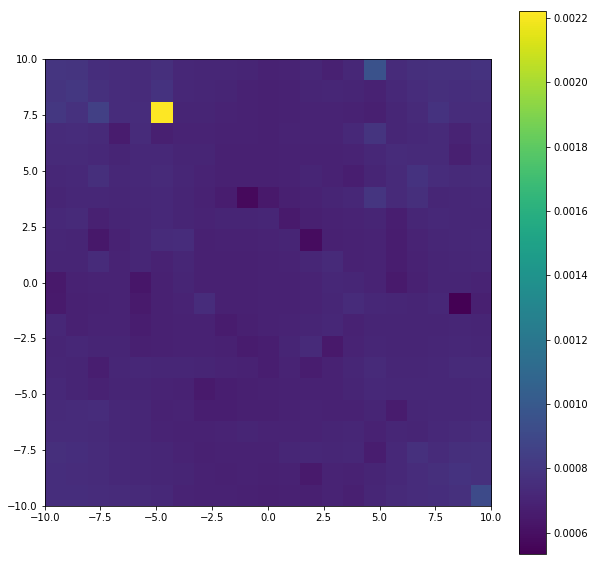

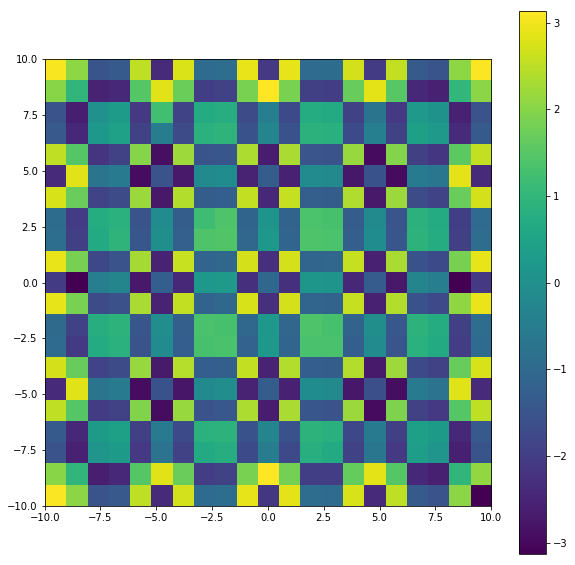

In [32]:
ints2 = np.abs(res/Fs)
plt.figure(figsize=(10,10))
plt.imshow(ints2, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()
ang2 = np.angle(res/Fs)
plt.figure(figsize=(10,10))
plt.imshow(ang2, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()

# Output values in overlap regions

In [153]:
diff2 = cbc.Diff(beam=beam,
                det_args=cbc.DetArgs(det_dist=det_dist, detNx=2*H, detNy=2*K+1, pix_size=pix_size),
                cell_args=cbc.CellArgs.importpdb('4et8.pdb'),
                lat_args=cbc.LatArgs(a=a, b=b, c=c, Nx=Nx, Ny=Ny, Nz=Nz))
diff2.move_lat([0.5 * a, 0.5 * b, 0.0])

In [154]:
diffres2 = diff2.henry().pool()
res2, kxs2, kys2 = diffres2.res, diffres2.kxs, diffres2.kys

In [142]:
kouts = cbc.kout_parax(kxs2.ravel(), kys2.ravel())
gxs1, gys1 = gxs[:, 0:2*H], gys[:, 0:2*H]
gxs2, gys2 = gxs[:, 1:2*H+1], gys[:, 1:2*H+1]
gs1 = np.stack((gxs1.ravel(), gys1.ravel(), np.repeat(0, gxs1.size)), axis=-1)
gs2 = np.stack((gxs2.ravel(), gys2.ravel(), np.repeat(0, gxs2.size)), axis=-1)
ss1 = np.sqrt(gs1*gs1).sum(axis=-1) / wavelength / 2e7
ss2 = np.sqrt(gs1*gs1).sum(axis=-1) / wavelength / 2e7
asfs1 = asf_sum(ss1.ravel(), asfcoeffs)
asfs2 = asf_sum(ss2.ravel(), asfcoeffs)
phs1 = phase(gs1, XS, YS, ZS, wavelength)
phs2 = phase(gs2, XS, YS, ZS, wavelength)
ufs1 = gaussian_f(gxs1.ravel(), gys1.ravel(), ZS, wavelength)
ufs2 = gaussian_f(gxs2.ravel(), gys2.ravel(), ZS, wavelength)
Fs1 = (asfs1 * phs1 * ufs1).sum(axis=-1).reshape(gxs1.shape)
Fs2 = (asfs2 * phs2 * ufs2).sum(axis=-1).reshape(gxs2.shape)
OLs = Fs1 + Fs2

In [10]:
ints4 = np.abs(OLs)
plt.figure(figsize=(10,10))
plt.imshow(ints4, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()
ang4 = np.angle(OLs)
plt.figure(figsize=(10,10))
plt.imshow(ang4, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()

NameError: name 'OLs' is not defined

# Lens beam

In [70]:
wavelength = 1.5e-7
f, ap, defoc = 2, 8e-2, 1e-4
a, b, c = 2e-6, 2e-6, 1e-5
Nx, Ny, Nz = 60, 60, 1
detNx, detNy = 128, 128
pix_size = 55e-3 / 2
det_dist = 30

In [71]:
print(wavelength / a, 2 * ap / f)

0.075 0.08


In [79]:
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz)
zs += 1e-4
xs -= 0.5001 * a
ys -= 0.5001 * b
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
Rs = np.sqrt(xs**2 + ys**2 + zs**2)
kins = cbc.lensbeam_kins(xs, ys, zs, f, wavelength)
us = cbc.cbeam(xs, ys, zs, f, ap, wavelength)

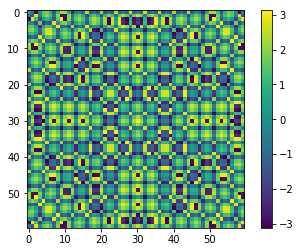

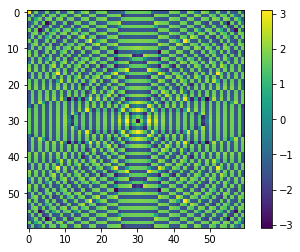

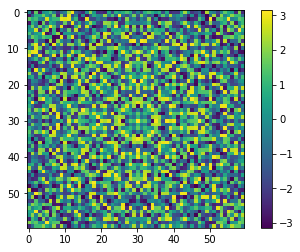

In [80]:
phin1 = (np.exp(1j) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)).reshape((Nx, Ny))
angs1 = np.angle(phin1)
angs2 = np.angle(np.exp(1j * np.pi) * np.exp(-1j * np.pi * 1e-2 / wavelength * (xs**2 + ys**2) / Rs**2)).reshape((Nx, Ny))
angs3 = -np.angle(us).reshape(Nx, Ny)
plt.imshow(angs1)
plt.colorbar()
plt.show()
plt.imshow(angs3)
plt.colorbar()
plt.show()
plt.imshow(angs2)
plt.colorbar()
plt.show()

In [82]:
qs_abs = cbc.utils.q_abs(kouts, kins, wavelength)
asf_coeffs1 = cbc.asf_coeffs()
%time asfs1 = cbc.utils.asf_sum(qs_abs, asf_coeffs1)
qs_abs.shape

CPU times: user 3.03 s, sys: 141 ms, total: 3.17 s
Wall time: 3.16 s


(16384, 3600, 1)

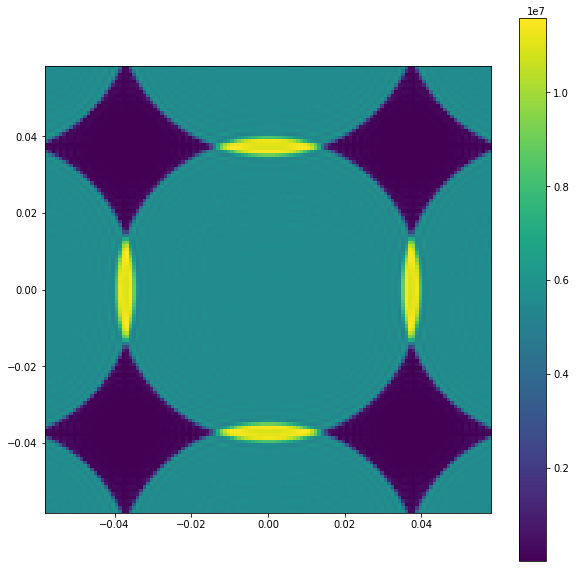

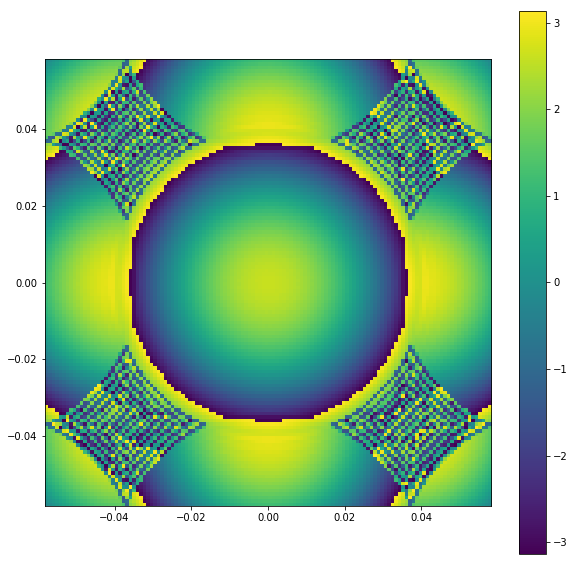

In [85]:
%matplotlib inline
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs1 * phs * us).sum(axis=(-2,-1)).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()
ang1 = np.angle(res)
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

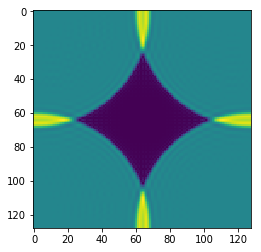

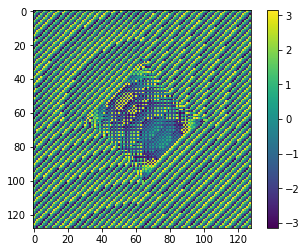

In [86]:
res2 = np.fft.fft2(us.reshape((Nx, Ny)), kxs.shape)
ints2 = np.abs(res2)
plt.imshow(ints2)
plt.show()
ang2 = np.angle(res2)
plt.imshow(ang2)
plt.colorbar()
plt.show()